In [92]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import cvxopt

import pickle

# Variable saving.


def pickleSave(var, filename='.pickle'):
    if '.pickle' not in filename:
        filename = filename + '.pickle'
    with open(filename, 'wb') as f:
        pickle.dump(var, f)
    print('PickleSave Succeeded.')
    return

# Variable loading.


def pickleLoad(filename):
    """
    Make sure it's assigned to a variable.
    """
    if '.pickle' not in filename:
        filename = filename + '.pickle'
    with open(filename, 'rb') as f:
        cache = pickle.load(f)
    print("PickleLoad Succeeded. Make sure it's assigned to a variable.")
    return cache


In [95]:
X = pickleLoad('X')
XHat_pR_IRLSPKS = pickleLoad('XHat_pR_IRLSPKS.pickle')
XHat_pR_ModCS = pickleLoad('XHat_pR_ModCS.pickle')
Means = pickleLoad('Means.pickle')
sampMats = pickleLoad('sampMats.pickle')
priorRatios = [0.,0.2,0.4,0.6,0.8,1.]
Supps = pickleLoad('Supps.pickle')

styles = ['^-','-.',':','*-',',-','-o','--','+-']

PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.


reweightedl1

PickleLoad Succeeded. Make sure it's assigned to a variable.


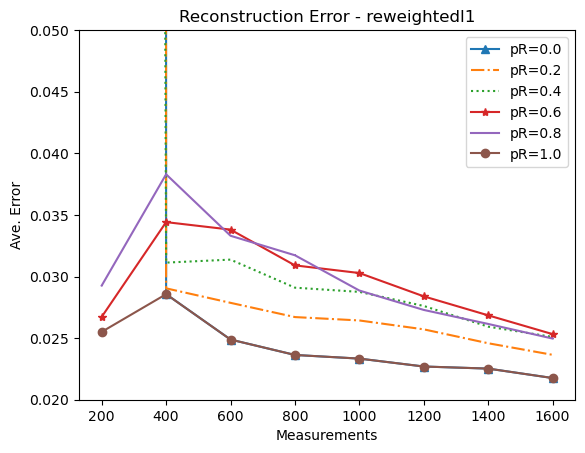

In [97]:
XHat_pR_reweightedl1 = pickleLoad('XHat_pR_reweightedl1')
errFig = []
for p in range(6):
    XHat_m = XHat_pR_reweightedl1[p]
    err = []
    for m in range(len(XHat_m)):
        XHat = XHat_m[m]
        err.append(np.sum((XHat - X)**2)/20)
    errFig.append(err)

numMeasurements = np.arange(200,1601,200)
priorRatios = [0.,0.2,0.4,0.6,0.8,1.]
for p in range(6):
    plt.plot(numMeasurements,errFig[p],styles[p],label='pR='+str(priorRatios[p]))
plt.legend()
plt.xlabel('Measurements')
plt.ylabel('Ave. Error')
plt.title('Reconstruction Error - reweightedl1')
plt.ylim(0.02,0.05)
plt.show()

IRLSPKS

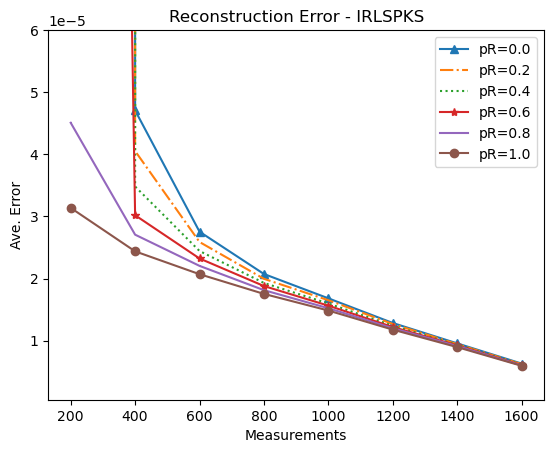

In [101]:
errFig = []
for p in range(6):
    XHat_m = XHat_pR_IRLSPKS[p]
    err = []
    for m in range(len(XHat_m)):
        XHat = XHat_m[m]
        err.append(np.sum((XHat - X)**2)/20)
    errFig.append(err)

numMeasurements = np.arange(200,1601,200)
priorRatios = [0.,0.2,0.4,0.6,0.8,1.]
for p in range(6):
    plt.plot(numMeasurements,errFig[p],styles[p],label='pR='+str(priorRatios[p]))
plt.legend()
plt.xlabel('Measurements')
plt.ylabel('Ave. Error')
plt.title('Reconstruction Error - IRLSPKS')
plt.ylim(5e-7,6e-5)
plt.show()

modCS

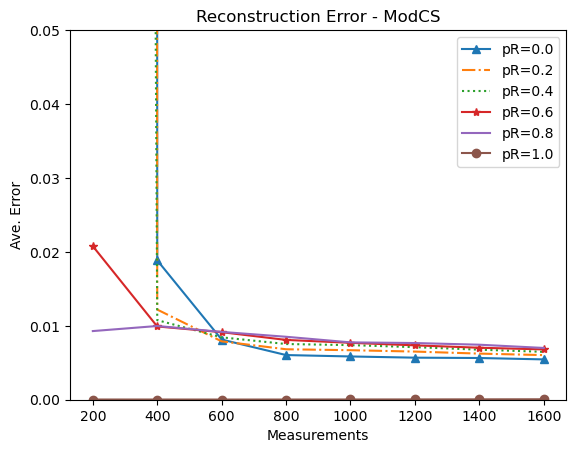

In [103]:
errFig = []
for p in range(6):
    XHat_m = XHat_pR_ModCS[p]
    err = []
    for m in range(len(XHat_m)):
        XHat = XHat_m[m]
        err.append(np.sum((XHat - X)**2)/20)
    errFig.append(err)

for p in range(6):
    plt.plot(numMeasurements,errFig[p],styles[p],label='pR='+str(priorRatios[p]))
plt.legend()
plt.xlabel('Measurements')
plt.ylabel('Ave. Error')
plt.title('Reconstruction Error - ModCS')
plt.ylim(0,0.05)
plt.show()

CosampPKS

PickleLoad Succeeded. Make sure it's assigned to a variable.


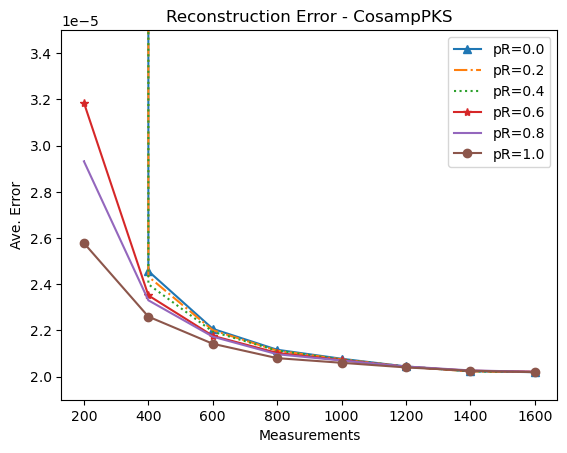

In [113]:
XHat_pR_CosampPKS = pickleLoad('XHat_pR_CosampPKS.pickle')
errFig = []
for p in range(6):
    XHat_m = XHat_pR_CosampPKS[p]
    err = []
    for m in range(len(XHat_m)):
        XHat = XHat_m[m]
        err.append(np.sum((XHat - X)**2)/20)
    errFig.append(err)

for p in range(6):
    plt.plot(numMeasurements,errFig[p],styles[p],label='pR='+str(priorRatios[p]))
plt.legend()
plt.xlabel('Measurements')
plt.ylabel('Ave. Error')
plt.title('Reconstruction Error - CosampPKS')
plt.ylim(1.9e-5,3.5e-5)
plt.show()

IHTPKS

PickleLoad Succeeded. Make sure it's assigned to a variable.


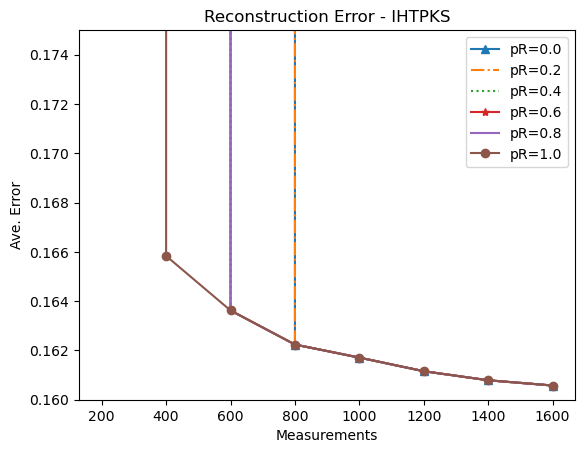

In [117]:
XHat_pR_IHTPKS = pickleLoad('XHat_pR_IHTPKS.pickle')
errFig = []
for p in range(6):
    XHat_m = XHat_pR_IHTPKS[p]
    err = []
    for m in range(len(XHat_m)):
        XHat = XHat_m[m]
        err.append(np.sum(np.abs(XHat - X))/20)
    errFig.append(err)

for p in range(6):
    plt.plot(numMeasurements,errFig[p],styles[p],label='pR='+str(priorRatios[p]))
plt.legend()
plt.xlabel('Measurements')
plt.ylabel('Ave. Error')
plt.title('Reconstruction Error - IHTPKS')
plt.ylim(0.16,0.175)
plt.show()

OMPPKS

PickleLoad Succeeded. Make sure it's assigned to a variable.


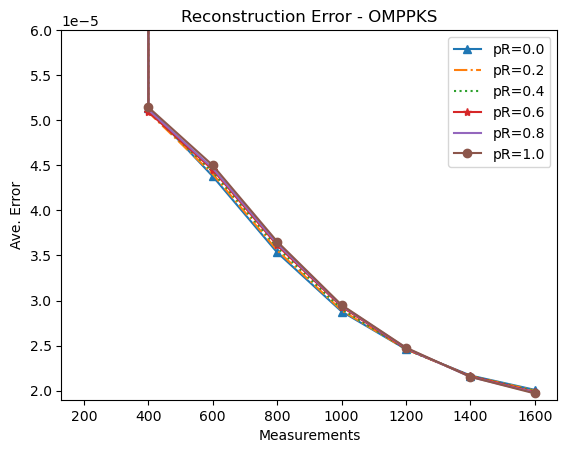

In [132]:
XHat_pR_OMPPKS = pickleLoad('XHat_pR_OMPPKS.pickle')
errFig = []
for p in range(6):
    XHat_m = XHat_pR_OMPPKS[p]
    err = []
    for m in range(len(XHat_m)):
        XHat = XHat_m[m]
        err.append(np.sum((XHat - X)**2)/20)
    errFig.append(err)

for p in range(6):
    plt.plot(numMeasurements,errFig[p],styles[p],label='pR='+str(priorRatios[p]))
plt.legend()
plt.xlabel('Measurements')
plt.ylabel('Ave. Error')
plt.title('Reconstruction Error - OMPPKS')
plt.ylim(1.9e-5,6e-5)
plt.show()

RWLSSl0PKS

PickleLoad Succeeded. Make sure it's assigned to a variable.


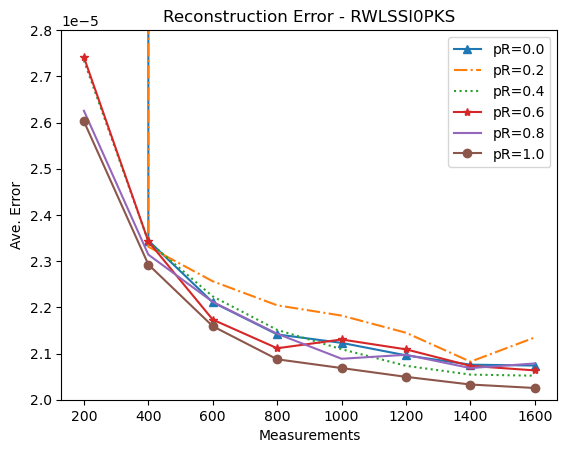

In [135]:
XHat_pR_RWLSSl0PKS = pickleLoad('XHat_pR_RWLSSl0PKS.pickle')
errFig = []
for p in range(6):
    XHat_m = XHat_pR_RWLSSl0PKS[p]
    err = []
    for m in range(len(XHat_m)):
        XHat = XHat_m[m]
        err.append(np.sum((XHat - X)**2)/20)
    errFig.append(err)

for p in range(6):
    plt.plot(numMeasurements,errFig[p],styles[p],label='pR='+str(priorRatios[p]))
plt.legend()
plt.xlabel('Measurements')
plt.ylabel('Ave. Error')
plt.title('Reconstruction Error - RWLSSl0PKS')
plt.ylim(2e-5,2.8e-5)
plt.show()

weightedl1

In [ ]:
XHat_pR_weightedl1 = pickleLoad('XHat_pR_weightedl1.pickle')
errFig = []
for p in range(6):
    XHat_m = XHat_pR_weightedl1[p]
    err = []
    for m in range(len(XHat_m)):
        XHat = XHat_m[m]
        err.append(np.sum((XHat - X)**2)/20)
    errFig.append(err)

for p in range(6):
    plt.plot(numMeasurements,errFig[p],styles[p],label='pR='+str(priorRatios[p]))
plt.legend()
plt.xlabel('Measurements')
plt.ylabel('Ave. Error')
plt.title('Reconstruction Error - weightedl1')
# plt.ylim(2e-5,3e-5)
plt.show()

regModBPDN

In [ ]:
XHat_pR_regModBPDN = pickleLoad('XHat_pR_regModBPDN.pickle')
errFig = []
for p in range(6):
    XHat_m = XHat_pR_regModBPDN[p]
    err = []
    for m in range(len(XHat_m)):
        XHat = XHat_m[m]
        err.append(np.sum((XHat - X)**2)/20)
    errFig.append(err)

for p in range(6):
    plt.plot(numMeasurements,errFig[p],styles[p],label='pR='+str(priorRatios[p]))
plt.legend()
plt.xlabel('Measurements')
plt.ylabel('Ave. Error')
plt.title('Reconstruction Error - regModBPDN')
# plt.ylim(2e-5,3e-5)
plt.show()